# Geolocation Matching

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import cos, sin, asin

pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = (15, 6)

%matplotlib inline

In [2]:
EARTH_RADIUS = 6371 * 1000  # meters

def get_haversine_distance(lat_1, lat_2, lon_1, lon_2):
    """Find the distance between `(lat_1, lon_1)` and `(lat_2, lon_2)`.
    """
    lat_1_rad, lon_1_rad = map(np.radians, [lat_1, lon_1])
    lat_2_rad, lon_2_rad = map(np.radians, [lat_2, lon_2])
    delta_lon = lon_2_rad - lon_1_rad
    delta_lat = lat_2_rad - lat_1_rad
    # Next two lines is the Haversine formula
    inverse_angle = (np.sin(delta_lat / 2) ** 2 +
                     np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(delta_lon / 2) ** 2)
    haversine_angle = 2 * np.arcsin(np.sqrt(inverse_angle))
    return haversine_angle * EARTH_RADIUS

## Data ingestion

In [3]:
country_code = 'AR'

**Cleaned operator data**

In [4]:
keep_columns = {'Client- Outlet Name': 'client-outlet_name_ohub',
                'Address': 'address_ohub',
                'Number': 'number_ohub',
                'Latitude': 'lat_ohub',
                'Longitude': 'lng_ohub'}

opr_geo = pd.read_csv('../../data/Phase_I/Phase_I_Input/AR_geolocation_clean.csv', sep=';', usecols=keep_columns.keys())
opr_geo.rename(columns=keep_columns, inplace=True)

print(opr_geo.shape)
opr_geo.head()

(11915, 5)


,client-outlet_name_ohub,address_ohub,number_ohub,lat_ohub,lng_ohub
0,CAICEDO MIRIAN,Francisco alvarez,2395.0,-32.917274,-68.832624
1,CATERBETTI FRANCO,Mendoza,2299.0,-34.560356,-58.456450
2,MAURE FERNANDO MARTIN,Pueyrredón,835.0,-32.908683,-68.826213
3,PULGAR PAOLA ROSANA,Tucuman,1161.0,-39.027775,-67.580741
4,LUPPI RICARDO NORBERTO SALVADOR,Avenida Córdoba,3249.0,-34.597641,-58.412588


**Google places data**

In [5]:
keep_columns = {'inputCountry': 'inputCountry',
                'outputCountry': 'country_google',
                'formattedAddress': 'address_google',
                'name': 'name_google',
                'lat': 'lat_google',
                'lng': 'lng_google',
                'placeId': 'placeId'}

opr_google = pd.read_csv('../../data/Phase_II/Phase_II_Output/OPR_ids_details.csv', sep=',', usecols=keep_columns.keys())
opr_google.rename(columns=keep_columns, inplace=True)
opr_google = opr_google.loc[opr_google.inputCountry == country_code].drop_duplicates(subset=['placeId'])
print(opr_google.shape)
opr_google.sample(10)

(71414, 7)


,address_google,inputCountry,lat_google,lng_google,name_google,country_google,placeId
78886,"C1218AAP, Av. Boedo 650, C1218AAP CABA, Argentina",AR,-34.620374,-58.416547,JII Nº08 MARIA A. SCHIAVONI DE LOPEZ DE 06,Argentina,ChIJyURqj_jKvJUR0ImlyMK_uvw
80227,"Gral. Manuel A. Rodríguez 2225, C1416CMW CABA, Argentina",AR,-34.599253,-58.456034,Tacop,Argentina,ChIJBWPTXQfKvJURgnhx3xbn8E4
86050,"Av. Galicia 95, B1868BGA Gran Buenos Aires, Buenos Aires, Argentina",AR,-34.676368,-58.383263,Heladería Lucero,Argentina,ChIJuU4sILjMvJURGDV-TieKK9k
47290,"San José 785, B1662DAP Muñiz, Buenos Aires, Argentina",AR,-34.545149,-58.700021,Heladeria Ciwe,Argentina,ChIJjyxX9Qa9vJURB8P51ylH60Y
14110,"Domingo French 191, B1828HKC Gran Buenos Aires, Buenos Aires, Argentina",AR,-34.742694,-58.396740,CIPRIANI'S,Argentina,ChIJE9MSt5_SvJURTW64whmFJr4
69376,"Tacuarí 1539, Buenos Aires, Argentina",AR,-34.626130,-58.377756,Model Institute of Dental Technique,Argentina,ChIJzzUoAi7LvJUROfoSx7d_BNU
25736,"Av. Corrientes 1660, Local 8, C1042ABE CABA, Argentina",AR,-34.605069,-58.390196,Vodevil,Argentina,ChIJ8a9-4cPKvJUR_3dJvduxWxY
18872,"Cerrito 1332, C1014 CABA, Argentina",AR,-34.592355,-58.382849,Frenchie,Argentina,ChIJWcDmqLDKvJURPmCmWQJ1oa4
22143,"Santiago del Estero, C1091 CABA, Argentina",AR,-34.611555,-58.384847,Crepes & Salafs,Argentina,ChIJJQ5dQ9rKvJURPK7_v_ohQiU
50368,"Dolores 112, C1407KGF CABA, Argentina",AR,-34.634112,-58.475851,HOTEL MIRIAM BROGNA,Argentina,ChIJ58E0c5DJvJURYqTwHDXXP5E


## Match using latitude and longitude

In [6]:
opr_geo.dtypes

client-outlet_name_ohub    object 
address_ohub               object 
number_ohub                float64
lat_ohub                   float64
lng_ohub                   float64
dtype: object

In [7]:
opr_google.dtypes

address_google    object 
inputCountry      object 
lat_google        float64
lng_google        float64
name_google       object 
country_google    object 
placeId           object 
dtype: object

**Retrieve closest observation based on geolocation**

In [10]:
def match_geolocations(row, keep_columns=None):
    keep_columns = keep_columns or ['lat_google', 'lng_google', 'address_google', 'country_google', 'name_google', 'placeId']
    
    diff = get_haversine_distance(row.lat_ohub, opr_google.lat_google, row.lng_ohub, opr_google.lng_google)
    index = diff.idxmin()
    row = row.append(opr_google.loc[index, keep_columns])
    row['diff_meters'] = diff[index]
    return row

In [11]:
opr_matches = opr_geo.apply(match_geolocations, axis=1)

In [12]:
opr_matches.number_ohub = opr_matches.number_ohub.fillna(-1).astype(int).astype(str)

In [13]:
opr_matches = opr_matches[['client-outlet_name_ohub', 'name_google', 'address_ohub', 'number_ohub', 'address_google', 'country_google', 'lat_ohub', 'lat_google', 'lng_ohub', 'lng_google', 'diff_meters']].sort_values('diff_meters')
opr_matches.head(20)

,client-outlet_name_ohub,name_google,address_ohub,number_ohub,address_google,country_google,lat_ohub,lat_google,lng_ohub,lng_google,diff_meters
5957,ESPINOZA ROJAS LUCINDA TEODORA,Miriam,Ibarrola,7186,"Planta Baja, Ibarrola 7184, C1408DXR CABA, Argentina",Argentina,-34.641710,-34.641710,-58.527130,-58.527130,0.0
4056,FITALE SRL,Lo de Fito,Mercedes,4280,"Mercedes 4280, C1419BGN CABA, Argentina",Argentina,-34.598676,-34.598676,-58.514380,-58.514380,0.0
8306,FFS GROUP SRL,Whoopies,Esteban Echeverria,3750,"Esteban Echeverria 3750, 1605 Munro, Buenos Aires, Argentina",Argentina,-34.514387,-34.514387,-58.522207,-58.522207,0.0
8302,PARDO LUIS ALBERTO,Pardo Home Brew Beer,Avenida Congreso,3330,"Av. Congreso 3330, C1430AZB CABA, Argentina",Argentina,-34.560535,-34.560535,-58.471915,-58.471915,0.0
4083,SALON MONSERRAT SRL,Hotel ACARA,Lima,265,"C1073AAE, Lima 265, C1073AAE CABA, Argentina",Argentina,-34.611459,-34.611459,-58.381949,-58.381949,0.0
4086,TENTACIONES ARGENTINAS S.R.L.,Parrilla Amarilla,Avenida San Juan,3136,"Av. San Juan 3136, C1233ABA CABA, Argentina",Argentina,-34.624778,-34.624778,-58.409381,-58.409381,0.0
472,CAFE DE POR MEDIO SRL,Escuela De Cafe,Carlos Calvo,565,"Carlos Calvo 565, C1102AAK CABA, Argentina",Argentina,-34.619590,-34.619590,-58.373765,-58.373765,0.0
8278,LONDON CALLING S.R.L,Luce Bar Cocina,Felipe Vallese,1599,"Felipe Vallese 1599, C1406FSC CABA, Argentina",Argentina,-34.617094,-34.617094,-58.456716,-58.456716,0.0
4093,LOITEGUI S A CONSTR. INM. Y FIN.,Loi Suites Recoleta Hotel,Vicente López,1955,"Vicente López 1955, 1128ACC CABA, Argentina",Argentina,-34.589474,-34.589474,-58.392524,-58.392524,0.0
4113,ANGEL MARTINEZ NATALIA,ZoomBar,Chile,356,"C1098AAH, Chile 356, C1098AAH CABA, Argentina",Argentina,-34.616020,-34.616020,-58.371125,-58.371125,0.0


Ohub number in google addres

In [14]:
opr_matches['match_number'] = opr_matches.apply(lambda x: x.number_ohub in x.address_google, axis=1)

### Summary

**Raw output matching data**

In [15]:
opr_matches.diff_meters.describe()

count    1.191500e+04
mean     4.609971e+05
std      3.551127e+05
min      0.000000e+00
25%      9.111190e+01
50%      4.456240e+05
75%      8.544284e+05
max      1.519136e+06
Name: diff_meters, dtype: float64

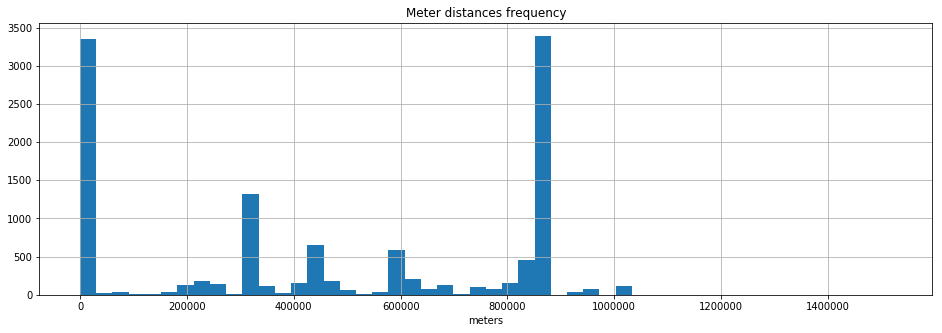

In [58]:
opr_matches.hist(column='diff_meters', figsize=(16, 5), bins=50)
plt.xlabel('meters')
plt.title('Meter distances frequency');

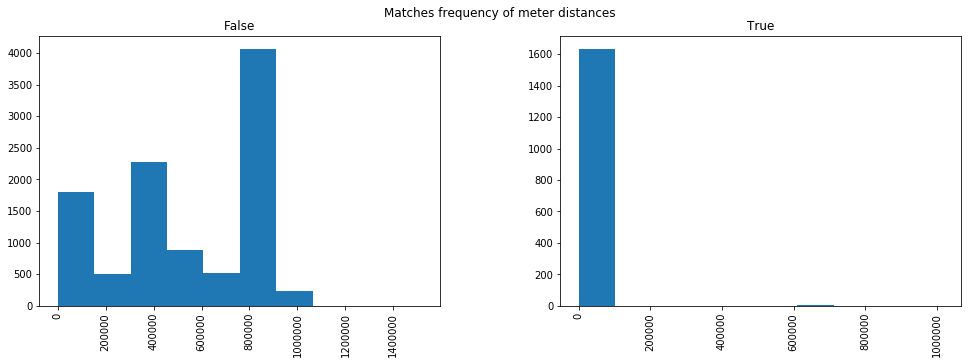

In [45]:
# separate: if ohub number is in the google address
opr_matches.hist(column='diff_meters', by='match_number', figsize=(16, 5), bins=10)
ax[0].set_xlabel('meters'), ax[1].set_xlabel('meters')
plt.suptitle('Matches frequency of meter distances');

In [18]:
opr_matches[~opr_matches.match_number].sort_values(by='diff_meters', ascending=True).head(100)

,client-outlet_name_ohub,name_google,address_ohub,number_ohub,address_google,country_google,lat_ohub,lat_google,lng_ohub,lng_google,diff_meters,match_number
5957,ESPINOZA ROJAS LUCINDA TEODORA,Miriam,Ibarrola,7186,"Planta Baja, Ibarrola 7184, C1408DXR CABA, Argentina",Argentina,-34.641710,-34.641710,-58.527130,-58.527130,0.000000e+00,False
2852,HOTELES DEL PLATA SA DE HOT. Y TUR.,Maria Pepe,Libertad,1020,"Libertad 1027, C1012AAU CABA, Argentina",Argentina,-34.596599,-34.596599,-58.384459,-58.384459,0.000000e+00,False
1188,REYES LOLIN LORENZO,Miriam,Ibarrola,7186,"Planta Baja, Ibarrola 7184, C1408DXR CABA, Argentina",Argentina,-34.641710,-34.641710,-58.527130,-58.527130,0.000000e+00,False
2729,BENEDIT SRL,Colegio San Jose,Avenida Córdoba,815,"Edificio Bencich, C1057 CABA, Argentina",Argentina,-34.598676,-34.598676,-58.378535,-58.378535,0.000000e+00,False
11428,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,False
1848,CAFE COMEGA S.R.L.,Estancia La Candelaria,Avenida Corrientes,224,"Av. Corrientes 222, C1043AAP CABA, Argentina",Argentina,-34.603237,-34.603237,-58.370665,-58.370665,0.000000e+00,False
11742,MAZZIERI IVAN LEONEL,Sláinte Irish Pub,Avenida San Martin,6080,"Av. San Martín 6066, Buenos Aires, Argentina",Argentina,-34.595371,-34.595371,-58.501610,-58.501610,0.000000e+00,False
11738,SERVICIOS COMPASS DE ARGENTINA S.A.,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,False
11697,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,False
11212,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,False


**Make cut-off of difference is more than 50 meters**

In [57]:
nearby_matches = opr_matches[opr_matches.diff_meters < 100]
print('Total maches:\t', opr_matches.shape[0])
print('Nearby matches (< 100 meters):\t', nearby_matches.shape[0])
print('Percentage:\t', round(100 * nearby_matches.shape[0] / opr_matches.shape[0], 2))

Total maches:	 11915
Nearby matches (< 100 meters):	 3026
Percentage:	 25.4


In [20]:
nearby_matches.diff_meters.describe()

count    2.770000e+03
mean     1.028128e+01
std      1.141981e+01
min      0.000000e+00
25%      1.414646e-09
50%      7.043979e+00
75%      1.498988e+01
max      4.991902e+01
Name: diff_meters, dtype: float64

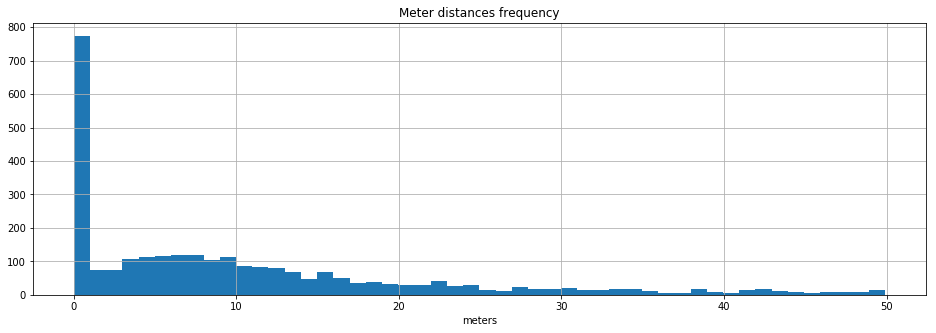

In [51]:
ax = nearby_matches.hist(column='diff_meters', figsize=(16, 5), bins=50)
plt.xlabel('meters')
plt.title('Meter distances frequency');

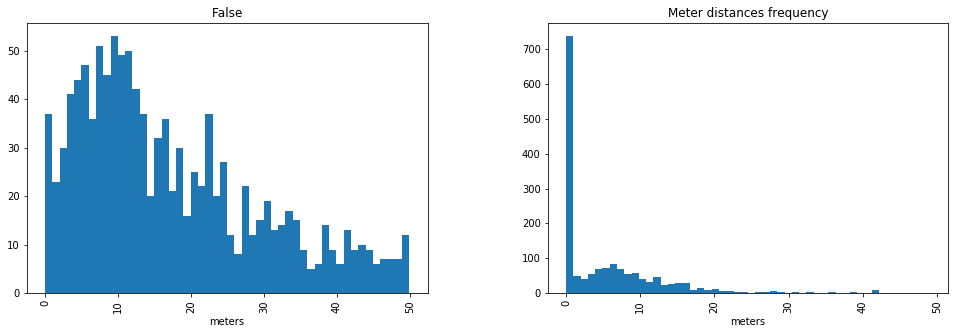

In [50]:
# separate: if ohub number is in the google address
ax = nearby_matches.hist(column='diff_meters', by='match_number', figsize=(16, 5), bins=50)
ax[0].set_xlabel('meters'), ax[1].set_xlabel('meters')
plt.title('Meter distances frequency');

dump as csv

In [23]:
opr_matches.sort_values(by='diff_meters', ascending=True).to_csv('AR_geolocation_matches.csv', header=True, index=False)